# MLP and CNN Experiments


Objective : To train MLPs and CNNs on MNIST, compare performance against baseline models, visualize embeddings using t-SNE, and test cross-domain generalization on Fashion-MNIST.


## 3.1 Using MLP

The objectives of this experiment are as follows:

1. **Train an MLP on the MNIST dataset**
   - Use a Multilayer Perceptron (MLP) with the following architecture:  
     - **Input layer:** Flattened 28×28 image  
     - **Hidden Layer 1:** 30 neurons  
     - **Hidden Layer 2:** 20 neurons  
     - **Output Layer:** 10 neurons (corresponding to the 10 digit classes)  
   - If computational resources are limited, use a **stratified subset** of the MNIST training dataset while keeping the **original test set** unchanged.

2. **Performance Comparison**
   - Compare the trained MLP model with **Random Forest** and **Logistic Regression** classifiers.  
   - Evaluate all models using the following metrics:  
     - Accuracy  
     - F1-score  
     - Confusion Matrix  
   - Analyze and discuss **misclassifications** observed across models.

3. **t-SNE Visualization**
   - Visualize **t-SNE embeddings** of the 20-neuron hidden layer for both **trained** and **untrained** MLP models.  
   - Compare the cluster separability of the 10 digit classes before and after training.

4. **Generalization Test on Fashion-MNIST**
   - Evaluate the trained MLP on the **Fashion-MNIST** dataset.  
   - Observe and discuss differences in performance and feature representations.  
   - Compare **t-SNE plots** of the 20-neuron layer embeddings for **MNIST** and **Fashion-MNIST** datasets.


Importing Libraries


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from sklearn.metrics import f1_score, confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

Setting Up Device

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():  # For Mac GPUs
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Working on device:", device)

Working on device: cpu


Setting the Random Seed

Setting a random seed ensures reproducibility by making all random operations—like matrix initialization and pixel masking—produce the same results every time. This allows consistent, verifiable experiments

In [10]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

Loading the MNIST Dataset

In [16]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms — convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Standard MNIST normalization
])

# Load MNIST training and test datasets
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

X_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

print("Train: X =", X_train.shape, "y =", y_train.shape)
print("Test: X =", X_test.shape, "y =", y_test.shape)

Train: X = (60000, 28, 28) y = (60000,)
Test: X = (10000, 28, 28) y = (10000,)


this will be used as flattened input layer 

Plotting Some Images 

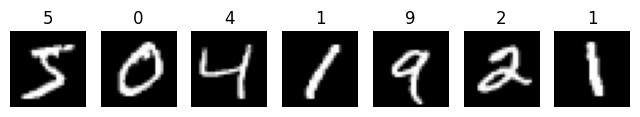

In [17]:
fig, axs = plt.subplots(1, 7, figsize=(8, 10))
for i in range(7):
    axs[i].imshow(X_train[i], cmap='gray')
    axs[i].set_title(y_train[i])
    axs[i].axis('off')

So we can see some of the handwritten digits and its predicition above 

* Creating the MLP Model  : Input layer will have 784 neurons;hidden layer 1 will have 30 neurons; hidden layer 2 will have 20 neurons and output layer will have 10 neurons

In [19]:
import torch.nn as nn
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 30)  # Input layer → Hidden layer 1
        self.fc2 = nn.Linear(30, 20)     # Hidden layer 1 → Hidden layer 2
        self.fc3 = nn.Linear(20, 10)     # Hidden layer 2 → Output (10 classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten image (batch, 1, 28, 28) → (batch, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)            # No activation here; CrossEntropyLoss applies softmax internally
        return x


Initializing Model

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)
summary(model, (1, 28, 28))

MLP(
  (fc1): Linear(in_features=784, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 30]          23,550
            Linear-2                   [-1, 20]             620
            Linear-3                   [-1, 10]             210
Total params: 24,380
Trainable params: 24,380
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.09
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


Training The MLP

In [ ]:
num_epochs = 10  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")


Epoch [1/10] Loss: 0.1553
Epoch [2/10] Loss: 0.1302
Epoch [3/10] Loss: 0.1126
Epoch [4/10] Loss: 0.1021
Epoch [5/10] Loss: 0.0918
Epoch [6/10] Loss: 0.0852
Epoch [7/10] Loss: 0.0793
Epoch [8/10] Loss: 0.0731
Epoch [9/10] Loss: 0.0692
Epoch [10/10] Loss: 0.0657


Evaluating on the test set

In [23]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 96.78%


Train Accuracy: 98.32%
Test Accuracy:  96.78%
Train F1 Score: 0.9831
Test F1 Score:  0.9675


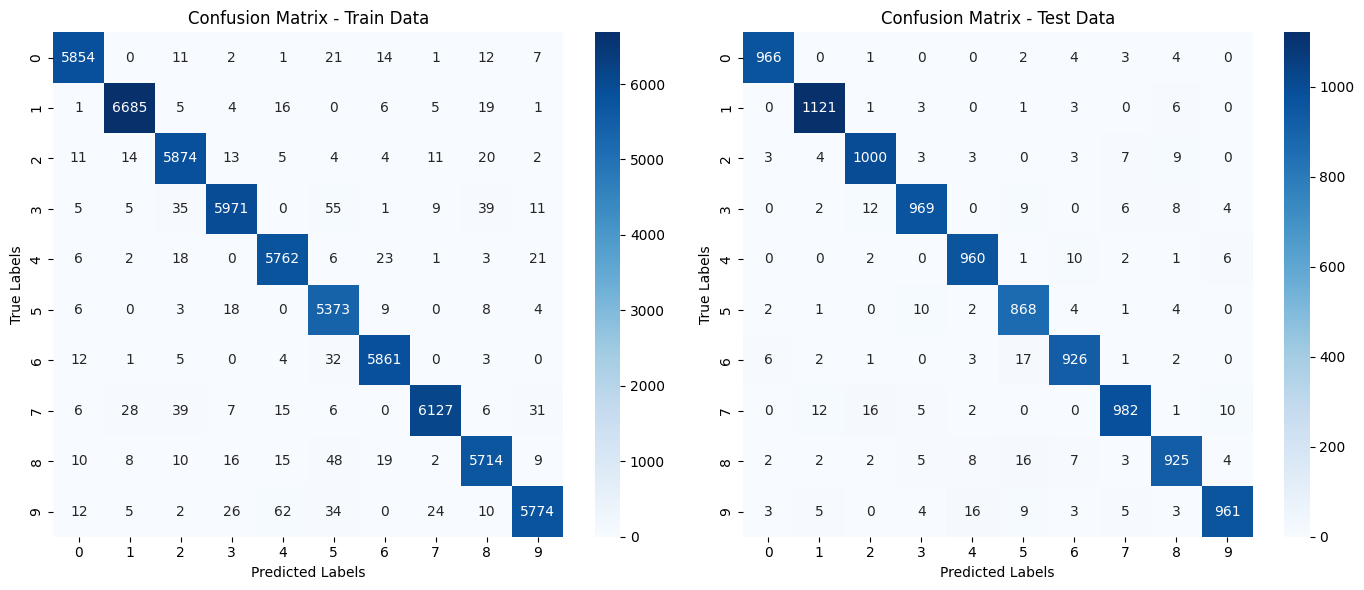

In [26]:
model.eval()


y_train_true = []
y_train_pred = []

with torch.no_grad():
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        y_train_true.extend(target.cpu().numpy())
        y_train_pred.extend(preds.cpu().numpy())


y_test_true = []
y_test_pred = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        y_test_true.extend(target.cpu().numpy())
        y_test_pred.extend(preds.cpu().numpy())

train_accuracy = accuracy_score(y_train_true, y_train_pred) * 100
test_accuracy = accuracy_score(y_test_true, y_test_pred) * 100

f1_train = f1_score(y_train_true, y_train_pred, average='macro')
f1_test = f1_score(y_test_true, y_test_pred, average='macro')

cm_train = confusion_matrix(y_train_true, y_train_pred)
cm_test = confusion_matrix(y_test_true, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy:  {test_accuracy:.2f}%")
print(f"Train F1 Score: {f1_train:.4f}")
print(f"Test F1 Score:  {f1_test:.4f}")

# ----- Plot confusion matrices -----
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Confusion Matrix - Train Data')
axs[0].set_xlabel('Predicted Labels')
axs[0].set_ylabel('True Labels')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('Confusion Matrix - Test Data')
axs[1].set_xlabel('Predicted Labels')
axs[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

In [27]:
print('Test Data Classification Report:')
print(classification_report(y_test, y_test_pred))

Test Data Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.96      0.96      1010
           4       0.97      0.98      0.97       982
           5       0.94      0.97      0.96       892
           6       0.96      0.97      0.97       958
           7       0.97      0.96      0.96      1028
           8       0.96      0.95      0.96       974
           9       0.98      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



Checking what it predicted wrong

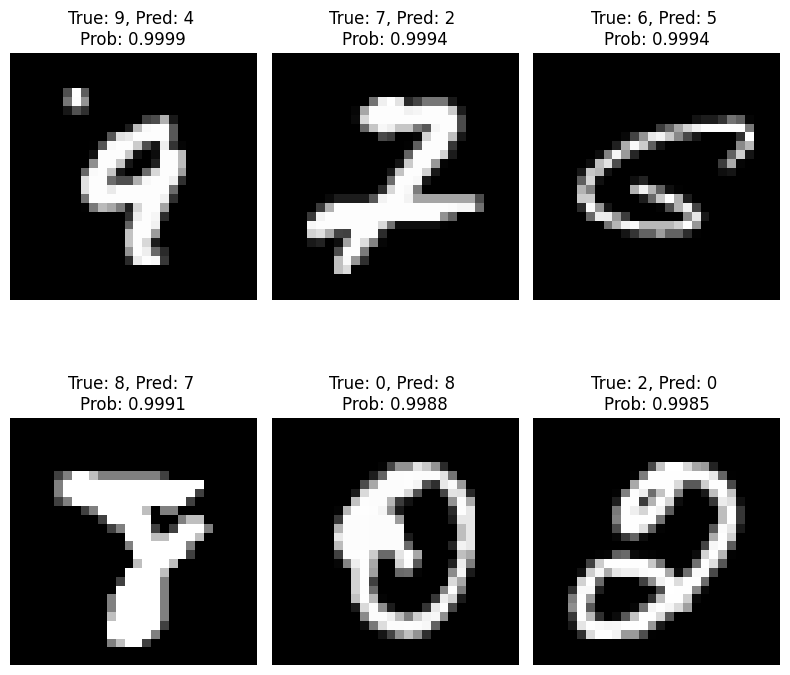

In [32]:
model.eval()
y_test_prob = []
y_test_true = []
y_test_pred = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)                  # logits
        probs = F.softmax(outputs, dim=1)      # convert to probabilities
        y_test_prob.extend(probs.cpu().numpy())
        y_test_true.extend(target.cpu().numpy())
        _, preds = torch.max(outputs, 1)
        y_test_pred.extend(preds.cpu().numpy())

y_test_prob = np.array(y_test_prob)
y_test_true = np.array(y_test_true)
y_test_pred = np.array(y_test_pred)

# --- Find misclassified samples ---
wrong_indices = np.where(y_test_true != y_test_pred)[0]
wrong_prob_max = np.max(y_test_prob[wrong_indices], axis=1)
topk = 6
topk_indices = np.argsort(wrong_prob_max)[::-1][:topk]

# --- Plot top-k misclassified images ---
fig, axs = plt.subplots(2, 3, figsize=(8, 8))
for i, idx in enumerate(topk_indices):
    ax = axs[i // 3, i % 3]
    img_idx = wrong_indices[idx]
    ax.imshow(X_test[img_idx], cmap='gray')
    ax.set_title(f'True: {y_test_true[img_idx]}, Pred: {y_test_pred[img_idx]} \nProb: {wrong_prob_max[idx]:.4f}')
    ax.axis('off')

plt.tight_layout()
plt.show()